# YouTube transcript - topic modeling
## Dawid Szyszko-Celiński (443709)

### Aim of the project

YouTube is one of the biggest social media sites with millions of creators and viewers around the world. On this site we can find a lot of information about certain topics within our interest. Conisdering this I asked myself a question if there is any way to make the analysis of YouTube videos? It is rather hard to analyse films as they consist of visual and sound data, however if we were able to obtain transcript of the videos as a textual data it would be much easier to work with it. Of course it is possible to analyse video using visual and sound data but it is out of the scope of this project.

The data that will be used was based on the "Elon Musk" query in search bar on YouTube. The whole data gathering process will be described in further parts of the project.

1) My first aim is to find out how to get the data from YouTube and check if it is possible.

2) I would also like to analyse text data to obtain the most popular topics for certain search on YouTube. From business perspective it might be useful for content creators to see what topics are "hot" and possibly help them to fit current trends that are promoted by YouTube algorithm.

3) I would also like to check if certain topics used in videos are somehow able to explain the number of views of the video. That is another business case for creators.

There could be many more use cases of topic modelling for YouTube data, that will not be included in this project, such as: detecting inapropriate content based on the topic rather than on certain keywords, checking if the title is clickbait or image manegement for businesses or people.

#### First let us load all necessary packages to perform analyses

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
import pandas as pd
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import TextFormatter
import re
import string
import nltk
from nltk.tokenize import word_tokenize # for tokenization
from nltk.stem import PorterStemmer # for stemming
from nltk.corpus import stopwords
import gensim
from gensim import corpora # for: Dictionary(), word2bow()
from gensim import models # for: TfidfModel()
import matplotlib.pyplot as plt # for plotting
import random
import statistics # for: quantiles()
import numpy as np # for some maths
import math
import warnings

from sklearn.decomposition import LatentDirichletAllocation # LDA implementation
from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM
from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer

import plotly.express as px # for nice plotting

from wordcloud import WordCloud # wordcloud implementation

import os
from os import path
from PIL import Image
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import tomotopy as tp 

from itertools import repeat
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

#### Please note that data will be provided in csv file, so running this part of code is not mandatory 

The next step is to set up necessary tools for Selenium library and create an empty data frame to hold the data.

The url is a link obtained after searching "Elon Musk" query with filter to obtain only videos from last year at maximus as we are interested in current topics that are connected with Elon Musk.

In [ ]:
## Path to geckodriver - please set up your path to geckodriver if you want to use the following code

gecko_path = ".../geckodriver.exe"
ser = Service(gecko_path)
options = webdriver.firefox.options.Options()
options.headless = False
driver = webdriver.Firefox(options = options, service=ser)


url = 'https://www.youtube.com/results?search_query=elon+musk&sp=CAASBAgFEAE%253D'
data = pd.DataFrame({'link':[], 'yt_id':[], 'title':[], 'transcript':[], 'views':[], 'time_uploaded':[], 'tokens':[], 'author':[], 'data_import_date':[]})

time_import = time.gmtime()

#### Actual scraping of YT (included code may not give the same results as youtube may list different / new videos)
#### Please skip this part of the code and use the data that was saved to csv file after running this script to follow the same results.
#### This part of the code is just a presentation of how the data was obtained

We will scrape video link, title, time when it was uploaded, views and author.

It is worth noting that the scrapping part does not click any items and destabilizes performance of YouTube platform. It is just scrolling down, to obtain all mentioned data from html of the scrolled page. Moreover there are included pauses in scrolling to make sure it is the least inconvenient for the platform resources.

Please not that browser that I used was displayed in Polish language and some clearing is done using polish words.

In [ ]:
driver.get(url)
time.sleep(10)

## Accept cookies / TOU

TOU = driver.find_element(by = By.XPATH, value = "/html/body/ytd-app/ytd-consent-bump-v2-lightbox/tp-yt-paper-dialog/div[4]/div[2]/div[6]/div[1]/ytd-button-renderer[2]/yt-button-shape/button/yt-touch-feedback-shape/div/div[2]")
TOU.click()

time.sleep(5)

## Scroll down

SCROLL_PAUSE_TIME = random.randrange(1,5,1)

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

s=0
i=0

while s <=300:
    SCROLL_PAUSE_TIME = random.randrange(3,7,1)
    s=s+1
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

    ## get the links

    time.sleep(1)

    vids = driver.find_elements(By.ID, "video-title")

    len(vids)

    j=0
    for i in vids:
        print(j)
        try:
            labels = i.get_attribute('aria-label')
            link = i.get_attribute('href')
            title = i.get_attribute('title')
            labels = i.get_attribute('aria-label')
            test = labels.find('dni') if labels else "skip"
            test2 = labels.find('dzie') if labels else "skip"


            if(labels.find('miesi') != -1):
                mk1 = labels.find('miesi')-2
                mk2 = labels.find('miesi')-1
                months = labels[ mk1 : mk2 ]
                month = int(months)
            else:
                month = 0

            if(labels.find('tydz') != -1 or labels.find('tygod') != -1):
                mk1 = labels.find('tygod')-2
                mk2 = labels.find('tygod')-1
                weeks = labels[ mk1 : mk2 ]
                if mk1 <0 :
                    mk1 = labels.find('tydz')-2
                    mk2 = labels.find('tydz')-1
                    weeks = labels[ mk1 : mk2 ]
                week = int(weeks)
            else:
                week = 0

            if(labels.find('dni') != -1 or labels.find('dzień') != -1):
                mk1 = labels.find('dni')-2
                mk2 = labels.find('dni')-1
                days = labels[ mk1 : mk2 ]
                if mk1 < 0 :
                    mk1 = labels.find('dzień')-2
                    mk2 = labels.find('dzień')-1
                    days = labels[ mk1 : mk2 ]
                days = int(days)
            else:
                days = 0

            if(labels.find('godz') != -1):
                mk1 = labels.find('godz')-3
                mk2 = labels.find('godz')-1
                hours = labels[ mk1 : mk2 ]
                hours = int(hours)
            else:
                hours = 0

            if(labels.find('minu') != -1):
                mk1 = labels.find('minu')-3
                mk2 = labels.find('minu')-1
                minutes = labels[ mk1 : mk2 ]
                minutes = int(minutes)
            else:
                minutes = 0

            time_uploaded = (month*30*24*60 + week*7*24*60 + days*24*60 + hours*60 + minutes)/60

            mk1 = labels.find('sekund')
            if mk1 < 0 :
                mk1 = labels.find('sekundy')
                if mk1 < 0 :
                     mk1 = labels.find('sekunda')
                     if mk1 < 0 :
                        mk1 = labels.find('minut')
                        if mk1 < 0 :
                            mk1 = labels.find('minuty')
                            if mk1 < 0 :
                                mk1 = labels.find('minuta')
                                if mk1 < 0 :
                                    mk1 = labels.find('godzin')
                                    if mk1 < 0 :
                                        mk1 = labels.find('godziny')
                                        if mk1 < 0 :
                                            mk1 = labels.find('godzina')
            mk2 = labels.find('wyświetleń')
            views = labels[ mk1 : mk2 ]
            views = re.sub("[A-Za-z]","",views)
            views = re.sub("ś",'',views)

            channel_info = driver.find_elements(By.ID,'channel-thumbnail')
            channel_info_i = channel_info[j]
            j=j+1

            channel = channel_info_i.get_attribute('href')
            
            upload = {'link':link,'title':title, 'time_uploaded':time_uploaded,'views':views, 'author':channel, 'yt_id':'x', 'transcript':'x', 'tokens':'x', 'data_import_date':time_import}
            data = data.append(upload, ignore_index = True)
        except:
            test = 0
driver.close()

#### Please also skip this part of the code and continue with next chunk when the data is loaded from csv file
Then we need to drop duplicates and rested indexinf of the data frame and then save the result to csv

In [ ]:
data = data.drop_duplicates(keep='first')
data.reset_index()

data_name = 'path to save csv'
data.to_csv(data_name)

#### Now let us load the scraped data from csv file and see how does it look like
#### We can also skip this part and load already transcripted data

In [ ]:
data_name = 'path to save csv' + 'data20230118_elon_musk.csv'
data = pd.read_csv(data_name)
del data['Unnamed: 0']
data.head()

### Getting transcripts
#### This part of the code can be performed or skipped and loaded already with obtained transcrips from another csv file

To get transcripts we need to use "youtube_transcript_api" package that is able to obtain transctipts given the id of the video.
ID of the video is a part after v= in each link.

For instance the ID of https://www.youtube.com/watch?v=hXIs2vtwDP0 is "hXIs2vtwDP0".

Please also note that we will look for english transcription only. Maybe in the future it would be a good idea to compare topics between different languages.

What is more some liks are a bit different (like the 5th row of data frame - https://www.youtube.com/shorts/JwKiCPBmgU8	) as they are reffering to "shorts" which does not contain transcripts and should be skipped.

In [ ]:
## get YT ID

for i in range(0, len(data)):
    link_text = data.at[i, 'link']
    reg = re.search('watch\?v=(.*)', str(link_text))
    try:
        yt_id = reg.group(1)
        data.at[i,'yt_id'] = yt_id
    except:
        data.at[i,'yt_id'] = 'x'

## Get YT transcripts

formatter = TextFormatter()

for i in range (0 ,len(data)):
    print(i)
    vid_id = data.at[i, 'yt_id']
    if vid_id != 'x':
        try:
            transcript = YouTubeTranscriptApi.get_transcript(vid_id)
            text_formated = formatter.format_transcript(transcript)
            data.at[i,'transcript'] = text_formated
        except:
            data.at[i,'transcript'] = 'x'
    else:
        data.at[i,'transcript'] = 'x'

data_backup = data.copy()

data_name = 'path to save csv' + 'data20230118_elon_musk_transcripted.csv'
#data.to_csv(data_name, sep=';')

### Load data with transcripts - we can start running code from this chunk !!!
We will also drop lines without transcript and reset index

In [2]:
data_name = 'path to save csv' + 'data20230118_elon_musk_transcripted.csv'

data = pd.read_csv(data_name, sep=";")
del data['Unnamed: 0']

data = data.drop(data[data.transcript == "x"].index)
data = data.reset_index()

In [3]:
data.describe()

,index,time_uploaded
count,269.000000,269.000000
mean,214.605948,1130.808488
std,135.389904,1551.273662
min,0.000000,0.066667
25%,96.000000,48.266667
50%,202.000000,720.133333
75%,337.000000,1440.200000
max,446.000000,6480.283333


### Preprocessing of the data

We can see that in the final analysis we will have 269 videos transcrips, but before the analysis we will need to get rid of special signs, white spaces, new lines etc.

In [4]:
## Data before
data.at[0,"transcript"]

"Tech billionaire Elon Musk takes over\nthe internet and once again as he just\nbought YouTube first he takes over\nTwitter and now YouTube Elon Musk does\nnot seem to be stopping why is Elon Musk\nbuying YouTube how is the public\nreacting to this what changes is Elon\nMusk going to make on YouTube join me\ntoday in this video where we will\nexplore why and how Elon Musk plans to\nbuy YouTube Elon Musk is actually the\nsecond richest person on the planet\nmeaning that none of us could have more\nmoney than the crazy high numbers Elon\nowns with great money also comes great\ninfluence Elon musk's influence in the\nsocial media industry Still Remains\nunmatched a single tweet from us\ndirectly impacts the prices of\ncryptocurrencies recently Elon Musk has\nbeen spending his fortune on some pretty\nexpensive things for example Twitter the\nrich Tech Enthusiast has recently called\ndibs on the microblogging site he bought\nTwitter by paying a whopping 44 billion\nAmerican dollars for all 

In [5]:
data["transcript"] = data["transcript"].map(lambda x: re.sub('\n', ' ', x))
data["transcript"] = data["transcript"].map(lambda x: re.sub(r'[0-9]+', '', x))
data["transcript"] = data["transcript"].map(lambda x: re.sub("[,\!?/:;''()``’“-”—#_]", '', x))
data["transcript"] = data["transcript"].map(lambda x: re.sub(r"([.]+)", '', x))
data["transcript"] = data["transcript"].map(lambda x: x.lower())
#data["transcript"] = data["transcript"].map(lambda x: re.sub(r'\b\w\b', '', x))
data["transcript"] = data["transcript"].map(lambda x: re.sub("music", '', x))
data["transcript"] = data["transcript"].map(lambda x: re.sub("\[\]", '', x))
data["transctipt"] = data["transcript"].map(lambda x: re.sub(" +", " ", x))

## Data after
data.at[0,"transcript"]

<>:3: DeprecationWarning: invalid escape sequence \!
<>:8: DeprecationWarning: invalid escape sequence \[
<>:3: DeprecationWarning: invalid escape sequence \!
<>:8: DeprecationWarning: invalid escape sequence \[
C:\Users\justy\AppData\Local\Temp/ipykernel_19572/3795489636.py:3: DeprecationWarning: invalid escape sequence \!
  data["transcript"] = data["transcript"].map(lambda x: re.sub("[,\!?/:;''()``’“-”—#_]", '', x))
C:\Users\justy\AppData\Local\Temp/ipykernel_19572/3795489636.py:8: DeprecationWarning: invalid escape sequence \[
  data["transcript"] = data["transcript"].map(lambda x: re.sub("\[\]", '', x))


'tech billionaire elon musk takes over the internet and once again as he just bought youtube first he takes over twitter and now youtube elon musk does not seem to be stopping why is elon musk buying youtube how is the public reacting to this what changes is elon musk going to make on youtube join me today in this video where we will explore why and how elon musk plans to buy youtube elon musk is actually the second richest person on the planet meaning that none of us could have more money than the crazy high numbers elon owns with great money also comes great influence elon musks influence in the social media industry still remains unmatched a single tweet from us directly impacts the prices of cryptocurrencies recently elon musk has been spending his fortune on some pretty expensive things for example twitter the rich tech enthusiast has recently called dibs on the microblogging site he bought twitter by paying a whopping  billion american dollars for all the shares of the company th

### Tokenize text
Now we have clear text in terms of structure, but there is still some work to do. We will need to separate each word (tokenization) and stem them to make sure we interpret simillar words the same ( for instance word "stop" and "stopped" have same meaning in terms of topic and should not be considered as 2 separate words)

In [6]:
## word_tokenize() applied to every single text

for i in range(0,len(data)):
    #print(i)
    data.at[i,'tokens'] = word_tokenize(data.at[i,'transcript'])

In [7]:
## Stemming

ps = PorterStemmer()

for i in range(0,len(data)):
    data.at[i,'tokens'] =[ps.stem(token) for token in data.at[i,'tokens']]
    
## Let`s see how does it look like
    
data.at[0,'tokens']

['tech',
 'billionair',
 'elon',
 'musk',
 'take',
 'over',
 'the',
 'internet',
 'and',
 'onc',
 'again',
 'as',
 'he',
 'just',
 'bought',
 'youtub',
 'first',
 'he',
 'take',
 'over',
 'twitter',
 'and',
 'now',
 'youtub',
 'elon',
 'musk',
 'doe',
 'not',
 'seem',
 'to',
 'be',
 'stop',
 'whi',
 'is',
 'elon',
 'musk',
 'buy',
 'youtub',
 'how',
 'is',
 'the',
 'public',
 'react',
 'to',
 'thi',
 'what',
 'chang',
 'is',
 'elon',
 'musk',
 'go',
 'to',
 'make',
 'on',
 'youtub',
 'join',
 'me',
 'today',
 'in',
 'thi',
 'video',
 'where',
 'we',
 'will',
 'explor',
 'whi',
 'and',
 'how',
 'elon',
 'musk',
 'plan',
 'to',
 'buy',
 'youtub',
 'elon',
 'musk',
 'is',
 'actual',
 'the',
 'second',
 'richest',
 'person',
 'on',
 'the',
 'planet',
 'mean',
 'that',
 'none',
 'of',
 'us',
 'could',
 'have',
 'more',
 'money',
 'than',
 'the',
 'crazi',
 'high',
 'number',
 'elon',
 'own',
 'with',
 'great',
 'money',
 'also',
 'come',
 'great',
 'influenc',
 'elon',
 'musk',
 'influenc',

### Removing stopwords
As we may expect YouTube videos can be quite messy as transcitps are basically spoken word that contains words such as "um", "uh" etc.

Moreover there are cetrain words that are used by content creators such as "like", "subscribe" etc.

There are also a lot of custom stopwords that were added as they does not bring any value added to topic modeling interpretation (some like "Elon" and "Musk" will be in each topic so there is also no sense to keep them as tokens)

The process of removing certain words wa itterative and based on many tests

In [8]:
## Basic stop words

stop_words = nltk.corpus.stopwords.words('english')

## Adding a few extra custom stopwords

new_stopwords = ["elon", "musk", "video", "like", "subscribe", "uh", "um", "yeah", "would", "could", "say", "got", "oh", "im", "dont", "see", "also", "use", "dude", "bro", "man", "yo", "lot", "thing", "guy", "okay", "said", "come", "take", "even", "didnt", "way", "want", "really", "us", "need", "mean", "if"]
stop_words.extend(new_stopwords)

## Preprocess the stopwords in the same way as the text

stop_words = pd.Series(stop_words).map(lambda x: re.sub('\n', '', x))
stop_words = stop_words.map(lambda x: re.sub("[,\!?/:;'\'()``]_", '', x))
stop_words = stop_words.map(lambda x: re.sub("'", '', x))
stop_words = stop_words.map(lambda x: re.sub(r"([.]+)", '', x))

## stemming stopwords
for i in range(0,len(stop_words)):
    stop_words[i] = ps.stem(stop_words[i])

## Let`s see some of them    
    
print(stop_words[1:20])

## making stopwords back a list
stop_words = list(stop_words)

## removing stopwords
for i in range(0,len(data)):
    data.at[i,'tokens'] = [word for word in data.at[i,'tokens'] if not word in list(stop_words)]

<>:13: DeprecationWarning: invalid escape sequence \!
<>:13: DeprecationWarning: invalid escape sequence \!
C:\Users\justy\AppData\Local\Temp/ipykernel_19572/495771552.py:13: DeprecationWarning: invalid escape sequence \!
  stop_words = stop_words.map(lambda x: re.sub("[,\!?/:;'\'()``]_", '', x))


1           me
2           my
3       myself
4           we
5          our
6          our
7      ourselv
8          you
9         your
10        youv
11       youll
12        youd
13        your
14        your
15    yourself
16    yourselv
17          he
18         him
19          hi
dtype: object


Let`s see the tokens after removing stopwords. They look much better then previously

In [9]:
data.at[0,'tokens']

['tech',
 'billionair',
 'internet',
 'bought',
 'youtub',
 'first',
 'twitter',
 'youtub',
 'seem',
 'stop',
 'buy',
 'youtub',
 'public',
 'react',
 'chang',
 'go',
 'make',
 'youtub',
 'join',
 'today',
 'explor',
 'plan',
 'buy',
 'youtub',
 'actual',
 'second',
 'richest',
 'person',
 'planet',
 'none',
 'money',
 'crazi',
 'high',
 'number',
 'great',
 'money',
 'great',
 'influenc',
 'influenc',
 'social',
 'media',
 'industri',
 'still',
 'remain',
 'unmatch',
 'singl',
 'tweet',
 'directli',
 'impact',
 'price',
 'cryptocurr',
 'recent',
 'spend',
 'fortun',
 'pretti',
 'expens',
 'exampl',
 'twitter',
 'rich',
 'tech',
 'enthusiast',
 'recent',
 'call',
 'dib',
 'microblog',
 'site',
 'bought',
 'twitter',
 'pay',
 'whop',
 'billion',
 'american',
 'dollar',
 'share',
 'compani',
 'valu',
 'fifti',
 'four',
 'dollar',
 'twenti',
 'cent',
 'per',
 'share',
 'enjoy',
 'throne',
 'ceo',
 'twitter',
 'step',
 'seen',
 'great',
 'invest',
 'approach',
 'sinc',
 'twitter',
 'pretti

### Making n-grams

Now let us create up to 3-grams to include some words that goes along with each other and can be treated as one. It is done after removing some of the words but still I think it is worth to include them.

In [10]:
def generate_ngrams(text, ngram = 1):
    temp = zip(*[text[i:] for i in range(0,ngram)])
    ans = [' '.join(ngram) for ngram in temp]
    ans = pd.Series(ans).map(lambda x: re.sub(" ", '_', x))
    return list(ans)


def listToString(s):  
    str1 = ""   
    for ele in s:  
        str1 += ele+" "    
    return str1


texts = data["tokens"].copy()
data["text preprocessed"] = texts.copy()

for i in range(0,len(data)):
    data["text preprocessed"][i] = listToString(data['tokens'][i])

for i in range(0,len(texts)):
    unigrams = texts[i]
    bigrams = generate_ngrams(texts[i], ngram = 2)
    trigrams = generate_ngrams(texts[i], ngram = 3)
    
    text = []
    text.append(unigrams)
    text.append(bigrams)
    text.append(trigrams)
    
    texts[i] = [item for sublist in text for item in sublist] 

C:\Users\justy\AppData\Local\Temp/ipykernel_19572/1492056585.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["text preprocessed"][i] = listToString(data['tokens'][i])


### TF

Let us define term frequency matrix and see the histogram of frequencies.

As expected there are a lot of unique tokens (especially after adding n-grams) but there is also second peak with higher frequencies)

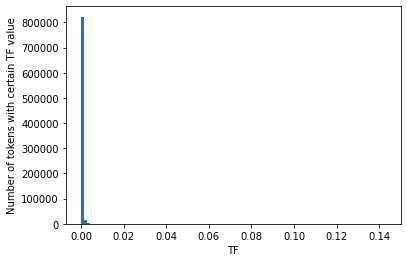

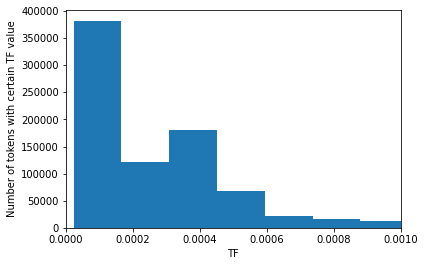

In [11]:
## TF

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

## define TF function

def TF(dictionary, corpus, which_text):

    bow = dict(corpus[which_text])
    bow_dict_combined = dict((dictionary[key], value) for (key, value) in bow.items())
    
    TFdictionary = {}
    bow_count = sum(bow_dict_combined.values()) #number of tokens in text
    
    for word, count in bow_dict_combined.items():
        TFdictionary[word] = count/bow_count
    
    return TFdictionary

## Check how it works

#TF(dictionary, corpus, 1) #Term Frequency in document no. 1

## Create a dictionary and check frequencies

d = {}

for i in range(0,len(corpus)):
    dat = TF(dictionary, corpus, i)

    for token, tf in dat.items(): 
        d.setdefault(token, []).append(tf)

tf_values = [item for sublist in list(d.values()) for item in sublist]

## Create histogram

plt.hist(tf_values, bins=100)
plt.xlabel('TF')
plt.ylabel('Number of tokens with certain TF value')
plt.show()

## Lets take a closer look at the begining of the scale

plt.hist(tf_values, bins=1000)
plt.xlabel('TF')
plt.ylabel('Number of tokens with certain TF value')
plt.xlim([0, 0.001]) # limit on x axis
plt.show()


### IDF
It`s the inversed TF - the higher the value the less frequent words

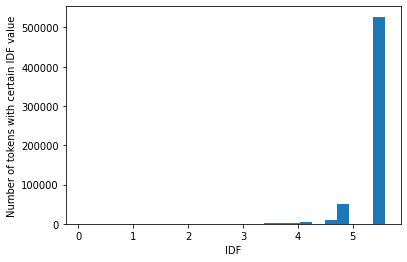

In [12]:
def IDF(corpus, dictionary):
    occurence = {}

    for i in range(0,len(corpus)):
    
        bow = dict(corpus[i])
        bow_dict_combined = dict((dictionary[key], value) for (key, value) in bow.items())

        for token, count in bow_dict_combined.items():
            occurence.setdefault(token, []).append(count)

    IDFdictionary = {}
        
    for token, counts in occurence.items():
        IDFdictionary[token] = np.log(len(corpus)/len(counts))
        
    return(IDFdictionary)


IDFdictionary = IDF(corpus, dictionary)

idf_values = list(IDFdictionary.values())

## histogram of IDF values
## please note that it is an inversen measure! 
## to remove least 'popular' terms we should remove the ones with highest IDF values
plt.hist(idf_values, bins=25)
plt.xlabel('IDF')
plt.ylabel('Number of tokens with certain IDF value')
plt.show()

### TF - IDF
It`s a combination of TF and IDF and it is used quite frequently in text analysis

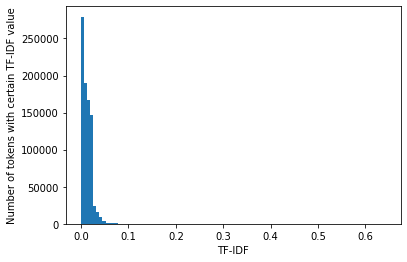

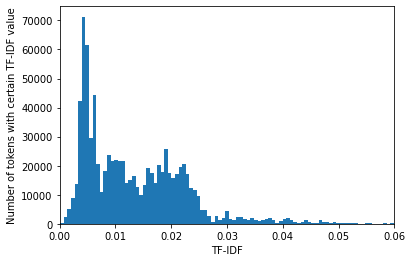

In [13]:
tfidf_model = models.TfidfModel(corpus, id2word = dictionary)

def TFIDF(dictionary, corpus, which_text, tfidf_model):
    bow = corpus[which_text]
    tfidfdictionary = dict(tfidf_model[bow]) #TFIDF for tokens in a chosen text
    
    #below: keys are tokens' names; values are numbers of tokens' occurences in text
    TFIDFdictionary = dict((dictionary[key], value) for (key, value) in tfidfdictionary.items())
    
    return(TFIDFdictionary)

## Test for 1 text

#print(TFIDF(dictionary, corpus, 1, tfidf_model))

## Lets calc TF-IDF for all texts

d_tfidf = {}

for i in range(0,len(corpus)):
    dat = TFIDF(dictionary, corpus, i, tfidf_model)

    for token, value in dat.items():
        d_tfidf.setdefault(token, []).append(value)

tfidf_values = [item for sublist in list(d_tfidf.values()) for item in sublist]

## Lets see the histogram

plt.hist(tfidf_values, bins=100)
plt.xlabel('TF-IDF')
plt.ylabel('Number of tokens with certain TF-IDF value')
plt.show()

plt.hist(tfidf_values, bins=1000)
plt.xlabel('TF-IDF')
plt.ylabel('Number of tokens with certain TF-IDF value')
plt.xlim([0, 0.06])
plt.show()

#### Now let us make one string from the words to be able to use WordCounter and TfIdfVecrorizer from "sklearn" package
Please note that some most common and least common words have been removed as they will rather make analysis worse than better (max_df = 0.7 and min_df = 5/len(data['tokens']). The thresholds were tested few times to make sure we get more or less optimal words for analysis

In [14]:
for i in range(0,len(data)):
    data['tokens'][i] = listToString(data['tokens'][i])

C:\Users\justy\AppData\Local\Temp/ipykernel_19572/1338836067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokens'][i] = listToString(data['tokens'][i])


In [15]:
tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tf_vectorizer = CountVectorizer(
                                max_df = 0.7, #filtering with document frequency
                                min_df = 5/len(data['tokens']), #filtering with document frequency
                                tokenizer = tokenizer.tokenize
)
tf = tf_vectorizer.fit_transform(data['tokens'])
tf_feature_names = tf_vectorizer.get_feature_names()

tfidf_vectorizer = TfidfVectorizer(
                                   max_df = 0.7, #filtering with document frequency
                                   min_df = 5/len(data['tokens']), #filtering with document frequency
                                   tokenizer = tokenizer.tokenize
)
tfidf = tfidf_vectorizer.fit_transform(data['tokens'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

C:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### LDA - TF
Let us perform one of the most common algorithms to obtain topics - Latent Dirichlet Allocation. For now I will use 30 topics and we will see if they make sense. Then we will follow up with checking optimal number of topics

In [16]:
lda = LatentDirichletAllocation(n_components = 30, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 5,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42
)

lda.fit(tf)

for index, component in enumerate(lda.components_): #taking model's components, i.e. P(w|z)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic


Topic 0:  ['mar', 'human', 'life', 'planet', 'must', 'red', 'environ', 'improv', 'establish', 'plan']
Topic 1:  ['unclear', 'ai', 'life', 'read', 'metavers', 'whether', 'oppress', 'import', 'tie', 'offici']
Topic 2:  ['object', 'fli', 'space', 'ai', 'spacex', 'earth', 'nasa', 'asteroid', 'sight', 'probabl']
Topic 3:  ['youtub', 'twitter', 'dave', 'boo', 'comedi', 'account', 'ban', 'platform', 'content', 'buy']
Topic 4:  ['neil', 'elderli', 'earliest', 'isol', 'twitter', 'youtub', 'ceo', 'question', 'wonder', 'investor']
Topic 5:  ['mar', 'human', 'life', 'earth', 'ai', 'planet', 'space', 'challeng', 'must', 'starship']
Topic 6:  ['ai', 'intellig', 'good', 'human', 'sustain', 'civil', 'immigr', 'exponenti', 'wage', 'quit']
Topic 7:  ['ai', 'intellig', 'good', 'end', 'human', 'question', 'build', 'danger', 'beat', 'univers']
Topic 8:  ['ai', 'probabl', 'univers', 'beat', 'end', 'stupid', 'build', 'kati', 'chica', 'dark']
Topic 9:  ['asteroid', 'ai', 'earth', 'object', 'school', 'intellig

#### Results
As we can see most of the topics makes sense and are quite expected when we think about "Elon Musk". For instance there are topics connected with space and SpaceX (Topic 0, 2, 5, 15 etc.), there are topics about Artificial Inteligence (Topic 1, 6, 7, 14 etc.), what is more we can see that there are topics mainly connected with Elom Musk Twitter acquisition and his decisions within company (Topic 3, 4, 10, 17, 21 etc.). There are also topic about other Elon Musk`s companies (Topic 24, 29). There are also some topics that are considering other topics such as politics or "aliens"? - (Topics 22, 23)

### LDA - TF-IDF
Let us perform the same algorithm on TF-IDF

In [17]:
lda = LatentDirichletAllocation(n_components = 30, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 5,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
lda.fit(tfidf)


for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['for', 'allow', 'stood', 'insan', 'orient', 'novel', 'evapor', 'period', 'quadrupl', 'vr']
Topic 1:  ['unclear', 'metavers', 'oppress', 'offici', 'abil', 'spectrum', 'empti', 'carpet', 'wet', 'valuabl']
Topic 2:  ['steve', 'trial', 'tesla', 'usa', 'san', 'francisco', 'thank', 'marijuana', 'date', 'latest']
Topic 3:  ['jeff', 'mainli', 'cabl', 'fix', 'isol', 'follow', 'cheap', 'versu', 'whoever', 'grasp']
Topic 4:  ['authent', 'love', 'descent', 'scroll', 'grace', 'ambiti', 'season', 'pro', 'sin', 'spinal']
Topic 5:  ['honor', 'expos', 'devic', 'transact', 'address', 'snl', 'u', 'younger', 'korean', 'zillion']
Topic 6:  ['twitter', 'media', 'investor', 'moder', 'behavior', 'medic', 'tweet', 'vaccin', 'court', 'social']
Topic 7:  ['secretli', 'icon', 'mental', 'spatial', 'fifti', 'norm', 'endors', 'q', 'discov', 'anderson']
Topic 8:  ['sharehold', 'investor', 'attorney', 'duti', 'neil', 'issu', 'sue', 'ceo', 'stupid', 'basi']
Topic 9:  ['offic', 'youtub', 'disrespect', 'leap',

#### Results
We can see that topics obtained with TF-IDF are quite different and in my opinion a bit harder to explain and connect by human, however let us try to analyse what topics do we have here. We can see that there is much less topics about space, but still there are quite significant number of the "Twitter" ones (Topic 6,12). We have also atopic about phones (Topic 11 - I have searched for some articles and found out that once Elon Musk stated that he will make his own phone as Apple phones are not the best. I was previously not aware that such topic existed). We have also somehow topic about "Andrew Tate" (Topic 20 - it is quite surprising that such topic is connected with Elon Musk). We have also topic 29 which at first glance sounds strange but I searched for the topic and it seems that "boxabl" is a house factory that was mentioned by Elon Musk (I was not aware of such topic). We have also topic 23 that is about politics and is rather negative.

Top sum up the topics obtained from TF-IDF are quite different (maybe a bit harder to understand) but they may give us some extra information that we are not aware considering certain topic or connections between searched topic and other topics. It seeems that there is quite big potential in this analysis in terms of new or less known topics that could be used by content creators

### Get the optimal number of topics
The 2 above examples of topics both for TF and TF-IDF made some sense, but now let us use some techniques to check the optimal nuber of topics. To make it we can use average topic coherence score and perplexity

In [18]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words, coherence_type):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    if(coherence_type == "uci"):
        for j_index in range(0, len(topic_top)):
            for i_index in range(0, j_index - 1):
                i = topic_top[i_index][1]
                j = topic_top[j_index][1]
                coherence += get_uci_score(dt_matrix, i, j)
    if(coherence_type == "uci_npmi"):
        for j_index in range(0, len(topic_top)):
            for i_index in range(0, j_index - 1):
                i = topic_top[i_index][1]
                j = topic_top[j_index][1]
                coherence += get_uci_npmi_score(dt_matrix, i, j)
    if(coherence_type == "umass"):
        for j_index in range(0, len(topic_top)):
            for i_index in range(0, j_index - 1):
                i = topic_top[i_index][1]
                j = topic_top[j_index][1]
                coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words, coherence_type):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words, coherence_type)
    return total_coherence / len(topics)

In [19]:
measures_specific = []

for n_topics in range(2,51,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 25,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
                
    lda.fit(tf)
    
    umass = get_average_topic_coherence(tf, lda.components_, 25,"umass")

    measures_specific.append([umass, n_topics])

measures_specific_df_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'umass', 1: 'n_topics'
})

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

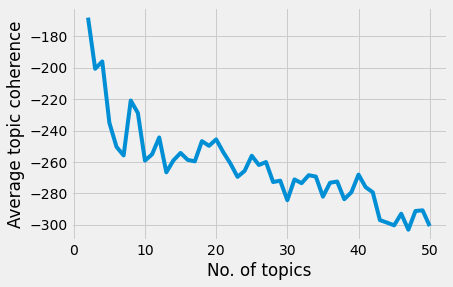

In [20]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_df_lda['n_topics'],measures_specific_df_lda['umass'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [21]:
measures_specific_df_lda.sort_values('umass', ascending = False).iloc[0:9,:]

,umass,n_topics
0,-167.991296,2
2,-195.943644,4
1,-200.616481,3
6,-220.855750,8
7,-228.804027,9
3,-235.094984,5
10,-244.414337,12
18,-245.650525,20
16,-246.784593,18


#### Results
Based on the place on the stabilized number of topics and highest average coherence it should be set at 20

#### Now let us cehck the perplexity
The perplexity measures shows that the higher number of topics the bigger the perplexity - we shall focus on average coherence to choose the optimal number of topics

In [22]:
measures_specific_perplex = []

for n_topics in range(2,51,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 25,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
                
    lda.fit(tfidf)
    
    perplexity = lda.perplexity(tf)

    measures_specific_perplex.append([perplexity, n_topics])

measures_specific_perplex_df_lda = pd.DataFrame(measures_specific_perplex).rename(columns={
    0: 'perplexity', 1: 'n_topics'
})

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

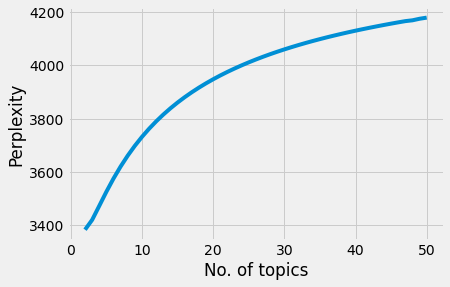

In [23]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_perplex_df_lda['n_topics'],measures_specific_perplex_df_lda['perplexity'])
plt.xlabel("No. of topics")
plt.ylabel("Perplexity")
plt.show()

In [24]:
measures_specific_perplex_df_lda.sort_values('perplexity', ascending = True).iloc[0:9,:]

,perplexity,n_topics
0,3382.353052,2
1,3419.256714,3
2,3472.001873,4
3,3525.145417,5
4,3574.758706,6
5,3619.984819,7
6,3660.918449,8
7,3697.944318,9
8,3731.507082,10


Now lets check TF-IDF

In [25]:
measures_specific_tf_idf = []

for n_topics in range(2,51,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 25,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
                
    lda.fit(tfidf)
    
    avg_coherence = get_average_topic_coherence(tfidf, lda.components_, 25, "umass")

    measures_specific_tf_idf.append([avg_coherence, n_topics])

# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_tfidf_lda = pd.DataFrame(measures_specific_tf_idf).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

Text(0, 0.5, 'Average topic coherence')

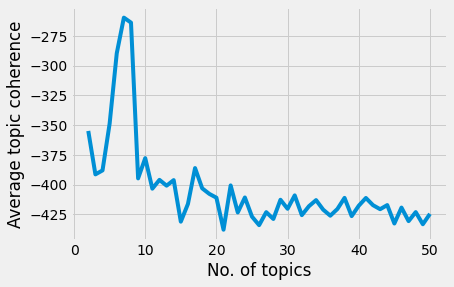

In [26]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_tfidf_lda['n_topics'],measures_specific_tfidf_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")

In [27]:
measures_specific_tfidf_lda.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,avg_coherence,n_topics
5,-259.575211,7
6,-263.772836,8
4,-289.560211,6
3,-348.630189,5
0,-354.839984,2
8,-377.687992,10
15,-386.039774,17
2,-388.001831,4
1,-391.364163,3


#### Results
Based on the place on the stabilized number of topics and highest average coherence it should be set at 17

TF-IDF perplexity

In [28]:
measures_specific_tfidf_perplex = []

for n_topics in range(2,51,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 25,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
                
    lda.fit(tfidf)
    
    perplexity = lda.perplexity(tfidf)

    measures_specific_tfidf_perplex.append([perplexity, n_topics])

measures_specific_tfidf_perplex_lda = pd.DataFrame(measures_specific_tfidf_perplex).rename(columns={
    0: 'perplexity', 1: 'n_topics'
})

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

Text(0, 0.5, 'Perplexity')

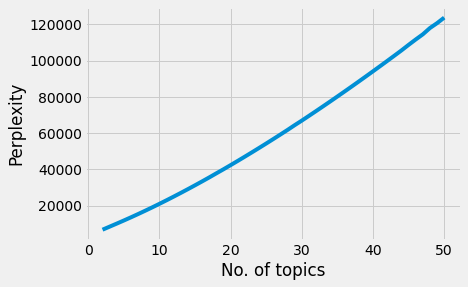

In [29]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_tfidf_perplex_lda['n_topics'],measures_specific_tfidf_perplex_lda['perplexity'])
plt.xlabel("No. of topics")
plt.ylabel("Perplexity")

In [30]:
measures_specific_tfidf_perplex_lda.sort_values('perplexity', ascending = True).iloc[0:9,:]

,perplexity,n_topics
0,6820.337627,2
1,8505.505402,3
2,10187.727042,4
3,11898.557274,5
4,13649.462589,6
5,15443.945553,7
6,17282.494007,8
7,19164.482412,9
8,21088.884397,10


Now LDA with optimal number of topics for TF

In [31]:
lda_tf = LatentDirichletAllocation(n_components = 20, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 25,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
lda_tf.fit(tf)

for index, component in enumerate(lda_tf.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic


Topic 0:  ['mar', 'human', 'life', 'spacex', 'ai', 'planet', 'space', 'improv', 'must', 'earth']
Topic 1:  ['ai', 'read', 'life', 'kind', 'good', 'issu', 'import', 'compani', 'twitter', 'whether']
Topic 2:  ['object', 'space', 'spacex', 'fli', 'ai', 'earth', 'nasa', 'sight', 'asteroid', 'ufo']
Topic 3:  ['biden', 'trump', 'presid', 'stori', 'democrat', 'state', 'govern', 'document', 'hunter', 'elect']
Topic 4:  ['twitter', 'youtub', 'tate', 'buy', 'account', 'content', 'question', 'ceo', 'compani', 'brother']
Topic 5:  ['mar', 'human', 'space', 'earth', 'object', 'planet', 'life', 'spacex', 'must', 'starship']
Topic 6:  ['ai', 'intellig', 'good', 'human', 'sustain', 'civil', 'exponenti', 'risk', 'quit', 'immigr']
Topic 7:  ['ai', 'intellig', 'question', 'good', 'ceo', 'human', 'end', 'univers', 'tesla', 'danger']
Topic 8:  ['ai', 'probabl', 'asteroid', 'univers', 'earth', 'beat', 'end', 'build', 'stupid', 'oper']
Topic 9:  ['neil', 'elderli', 'oversight', 'puzzl', 'asteroid', 'ai', 'hu

We can see that compared to first 30 topics they are quite similar

Best number of topics for TF-IDF

In [32]:
lda_tfidf = LatentDirichletAllocation(n_components = 17, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 25,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
lda_tfidf.fit(tfidf)

LatentDirichletAllocation(batch_size=8, learning_method='online',
                          learning_offset=50.0, max_iter=25, n_components=17,
                          random_state=42)

In [33]:
for index, component in enumerate(lda_tfidf.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tfidf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['mar', 'nasa', 'planet', 'earth', 'surfac', 'red', 'atmospher', 'discoveri', 'rock', 'mission']
Topic 1:  ['twitter', 'tesla', 'compani', 'ai', 'theyr', 'car', 'human', 'actual', 'dollar', 'tweet']
Topic 2:  ['equival', 'insist', 'stori', 'usual', 'spectrum', 'gertrud', 'circul', 'walk', 'disagr', 'fli']
Topic 3:  ['ai', 'human', 'alien', 'laugh', 'intellig', 'savag', 'car', 'youtub', 'jeff', 'game']
Topic 4:  ['usa', 'thank', 'latest', 'date', 'foreign', 'youtub', 'check', 'news', 'stay', 'hey']
Topic 5:  ['honor', 'expos', 'devic', 'transact', 'address', 'snl', 'u', 'younger', 'korean', 'zillion']
Topic 6:  ['immigr', 'wage', 'stadium', 'rig', 'program', 'openli', 'greatli', 'amazingli', 'plausibl', 'blind']
Topic 7:  ['pyramid', 'tate', 'tesla', 'twitter', 'construct', 'ancient', 'quantum', 'tweet', 'structur', 'galaxi']
Topic 8:  ['ai', 'intellig', 'digit', 'sustain', 'stupid', 'benign', 'kati', 'chica', 'singular', 'human']
Topic 9:  ['offic', 'youtub', 'disrespect', 'l

As far as I can assess the quality 30 topics vs 17 topics it seems that higher number did better. We could obtain a bit more konwledge that is why I will use bigger number of topics in the future analyses.

#### Number of topics
Considering the specificity of the data (some videos may contain a lot of topics) it is rather good idea to include bigger number of topics for modeling to obtain more insightful topics. Maybe some of topics will have no sense but some of them will be much more helpful in topic analysis

In [34]:
def plot_top_words_per_topic(model, feature_names, n_top_words = 10, topic_idx = 0):
    topic = model.components_[topic_idx]
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
    ax.tick_params(axis="both", which="major", labelsize=20)

#### Let us visualize some topics

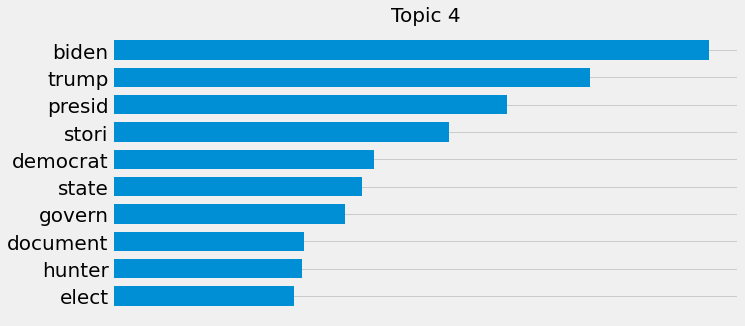

In [35]:
plot_top_words_per_topic(lda_tf, tf_feature_names, n_top_words = 10, topic_idx = 3)

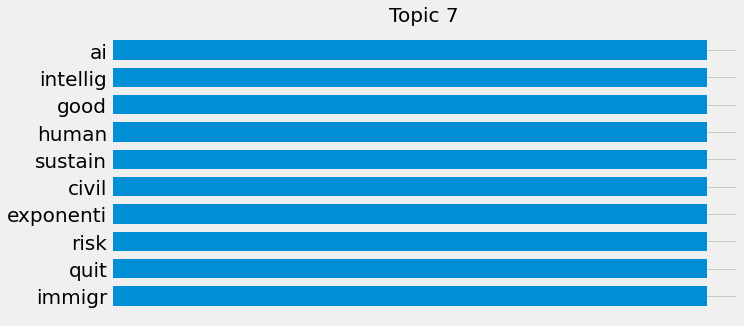

In [36]:
plot_top_words_per_topic(lda_tf, tf_feature_names, n_top_words = 10, topic_idx = 6)

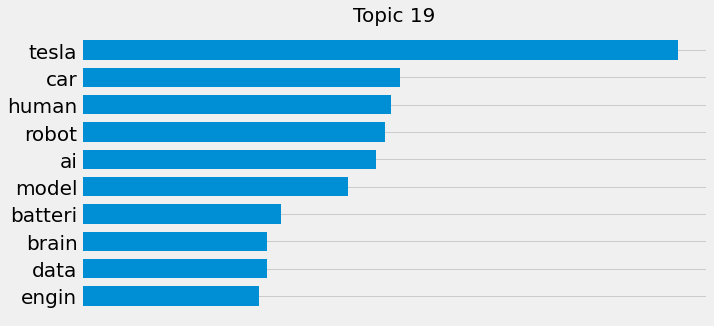

In [37]:
plot_top_words_per_topic(lda_tf, tf_feature_names, n_top_words = 10, topic_idx = 18)

#### Final models with 50 topics
Even if they are not most optimal in terms of coherence or perplexity I will use them as they help us to make better insight into topics of videos

In [44]:
lda_tf = LatentDirichletAllocation(n_components = 50, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 25,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
lda_tf.fit(tf)

for index, component in enumerate(lda_tf.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['mar', 'planet', 'human', 'environ', 'must', 'life', 'red', 'establish', 'plan', 'improv']
Topic 1:  ['unclear', 'metavers', 'oppress', 'offici', 'abil', 'spectrum', 'empti', 'carpet', 'wet', 'valuabl']
Topic 2:  ['fli', 'object', 'spacex', 'space', 'sight', 'nasa', 'ufo', 'earth', 'appear', 'sinc']
Topic 3:  ['youtub', 'twitter', 'content', 'platform', 'account', 'chang', 'post', 'ban', 'sinc', 'buy']
Topic 4:  ['youtub', 'kamala', 'twitter', 'vice', 'buy', 'content', 'account', 'chang', 'immigr', 'brown']
Topic 5:  ['mar', 'human', 'planet', 'earth', 'life', 'starship', 'must', 'warn', 'space', 'despit']
Topic 6:  ['immigr', 'wage', 'stadium', 'rig', 'program', 'openli', 'greatli', 'amazingli', 'plausibl', 'blind']
Topic 7:  ['ai', 'intellig', 'end', 'good', 'human', 'question', 'beat', 'danger', 'univers', 'religion']
Topic 8:  ['stupid', 'kati', 'chica', 'monkey', 'oper', 'bubbl', 'michigan', 'incent', 'famous', 'provid']
Topic 9:  ['asteroid', 'earth', 'surfac', 'sampl'

By extending topics to 50 we got new insights such as topic about covid (Topic 40) and a bit more extended topics about AI and YouTube / Twitter

In [45]:
lda_tfidf = LatentDirichletAllocation(n_components = 50, 
                                doc_topic_prior = None, 
                                topic_word_prior = None, 
                                learning_method = 'online', 
                                learning_decay = 0.7, 
                                learning_offset = 50.0, 
                                max_iter = 25,
                                batch_size = 8,
                                evaluate_every = -1,
                                total_samples = 1000000.0, 
                                perp_tol = 0.1,
                                mean_change_tol = 0.001,
                                max_doc_update_iter = 100, 
                                n_jobs = None,      
                                verbose = 0, 
                                random_state = 42)
lda_tfidf.fit(tfidf)

for index, component in enumerate(lda_tfidf.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tfidf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['ai', 'human', 'asteroid', 'intellig', 'danger', 'surfac', 'destroy', 'artifici', 'believ', 'purpos']
Topic 1:  ['unclear', 'metavers', 'oppress', 'offici', 'abil', 'spectrum', 'empti', 'carpet', 'wet', 'valuabl']
Topic 2:  ['equival', 'insist', 'stori', 'usual', 'spectrum', 'gertrud', 'circul', 'walk', 'disagr', 'fli']
Topic 3:  ['jeff', 'mainli', 'cabl', 'fix', 'isol', 'follow', 'cheap', 'versu', 'whoever', 'grasp']
Topic 4:  ['authent', 'love', 'descent', 'scroll', 'grace', 'ambiti', 'season', 'pro', 'sin', 'spinal']
Topic 5:  ['honor', 'expos', 'devic', 'transact', 'address', 'snl', 'u', 'younger', 'korean', 'zillion']
Topic 6:  ['immigr', 'wage', 'stadium', 'rig', 'program', 'openli', 'greatli', 'amazingli', 'plausibl', 'blind']
Topic 7:  ['pyramid', 'construct', 'ancient', 'structur', 'chamber', 'egypt', 'archaeologist', 'build', 'built', 'theori']
Topic 8:  ['stupid', 'kati', 'chica', 'monkey', 'oper', 'bubbl', 'michigan', 'incent', 'famous', 'provid']
Topic 9:  ['ste

#### Topics shres in each video
Let us check examplary viedo and share of each topic in this video. When we find a video that interest us we can see how big shares of each topic it covers

In [46]:
doc_topic_probs = pd.DataFrame(lda_tf.transform(tf))
doc_topic_probs

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,...,0.000024,0.000024,0.875357,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024
1,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,...,0.000023,0.000023,0.292512,0.000023,0.039338,0.000023,0.000023,0.000023,0.000023,0.000023
2,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,...,0.000019,0.000019,0.576157,0.000019,0.023710,0.000019,0.000019,0.000019,0.000019,0.000019
3,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,...,0.000024,0.000024,0.193372,0.000024,0.027440,0.000024,0.000024,0.000024,0.000024,0.000024
4,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,...,0.000025,0.000025,0.237683,0.000025,0.524087,0.110627,0.000025,0.000025,0.000025,0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,...,0.000027,0.000027,0.142017,0.000027,0.567393,0.242238,0.000027,0.000027,0.000027,0.000027
265,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,...,0.000049,0.000049,0.782485,0.000049,0.000049,0.215168,0.000049,0.000049,0.000049,0.000049
266,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,...,0.000023,0.000023,0.158242,0.000023,0.031495,0.741846,0.000023,0.000023,0.000023,0.000023
267,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,...,0.000097,0.000097,0.794082,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097


In [47]:
def document_topic_structure(model, raw_data, feature_names, doc_topic_probs, which_doc, text_length, n_top_words_per_topic):
    
    no_top_topics = sum(doc_topic_probs.iloc[which_doc]>0.01)

    print("Document no. ",which_doc,':\n', sep = '')
    print(raw_data[which_doc][0:text_length], '...', '\n', sep = '')
    
    print("Top",no_top_topics,"topics are:", list(doc_topic_probs.iloc[which_doc].sort_values(ascending=False)[0:no_top_topics].index), '\n', sep = ' ')
    
    labels = [None] * len(doc_topic_probs.transpose())
    j = 0
    for i in list(doc_topic_probs.iloc[which_doc].sort_values(ascending=False)[0:no_top_topics].index):
    
        topic = model.components_[i]
        top_features_ind = topic.argsort()[: -n_top_words_per_topic - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        labels[j] = 'topic #'+str(i)
        j += 1
        print('Topic ', i, ': ', top_features, sep = '')
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.pie(doc_topic_probs.iloc[which_doc].sort_values(ascending=False), labels = labels)

#### Twitter video

Document no. 0:

tech billionair internet bought youtub first twitter youtub seem stop buy youtub public react chang go make youtub join today explor plan buy youtub actual second richest person planet none money crazi high number great money great influenc influenc social media industri still remain unmatch singl tweet directli impact price cryptocurr recent spend fortun pretti expens exampl twitter rich tech enthusiast recent call dib microblog site bought twitter pay whop billion american dollar share compani valu fifti four dollar twenti cent per share enjoy throne ceo twitter step seen great invest approach sinc twitter pretti valuabl entiti twitter report second quarter almost million monetiz daili activ account mani user open account side coin shown great amount peopl twitter daili great amount peopl great amount money howev claim bought twitter human state civil common digit town squar twitter becom free-for-al hellscap anyth consequ platform must adher law land bought twitter 

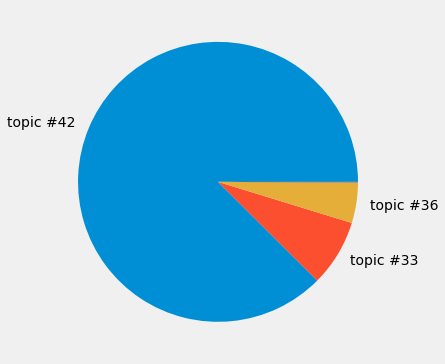

In [48]:
document_topic_structure(lda_tf, 
                         data['tokens'],
                         tf_feature_names,
                         doc_topic_probs, 
                         which_doc = 0, 
                         text_length = 50000,
                         n_top_words_per_topic = 10)

#### Elon Musk Companies in general video

Document no. 20:

exclus give lectur home bel-air everybodi listen think regular school good enough job prepar kid big propon teach peopl think base first principl figur work boil basic exampl peopl thought radic improv rocketri imposs space agenc privat compani tri build reusabl rocket fail one kind work nasa space shuttl - cost refurbish booster fish ocean great make sens look ‘ well make work therefor work basi realiti first principl foundat approach ‘ let look physic econom rocket ‘ analyz physic rocket physic possibl first principl think break cost rocket materi figur reassembl materi produc afford rocket…which spacex mission ad astra school origin began spacex rocket facil hawthorn california teach children kid employe move hous coupl year one formerli belong gene wilder guest lectur teacher help creat curriculum josh dahn josh cindi dahn taught one son privat school gift children la spacex ceo approach start experiment school rocket factori direct make school great great look lo

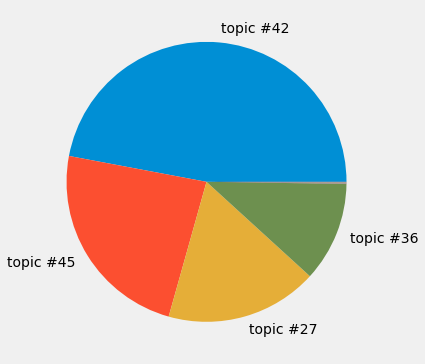

In [49]:
document_topic_structure(lda_tf, 
                         data['tokens'],
                         tf_feature_names,
                         doc_topic_probs, 
                         which_doc = 20, 
                         text_length = 50000,
                         n_top_words_per_topic = 10)

#### Political video

Document no. 268:

cove wors know enough wors get attent undeni differ polit convers around brett weinstein releas straight podcast danger vaccin variabl chang look leav covet exactli chang make preferenti danger children rather old peopl smile small one variabl vaccin actual block transmiss vaccin actual fact good let vaccin block transmiss noth els give littl transmiss blockag give kid preferenti kill injur laugh sub serious think platform peopl obvious unwel unbalanc profession mental around vaccin sorri let stop rewind night first hashtag confess project mr sam harri give kid preferenti kill injur diseas conspiraci think platform peopl obvious unwel unbalanc profession mental around vaccin skeptic patienc non-exist one insan idiot ever heard let stop owner copyright holder billi madison claim two-hour stream show second icon scene cinemat histori peopl peopl rumbl work hold work rumbl work ive interrupt mojo whoever worri angri thank let know sam harri one insan idiot ever heard po

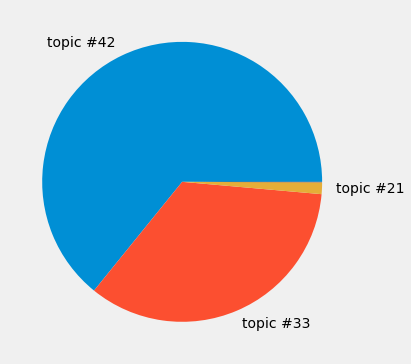

In [50]:
document_topic_structure(lda_tf, 
                         data['tokens'],
                         tf_feature_names,
                         doc_topic_probs, 
                         which_doc = 268, 
                         text_length = 50000,
                         n_top_words_per_topic = 10)

### Changes of topic in time
Let us examine how the certain topics have cahnged over time

The X axis shows hours from the oldes video in the dataset (because of the number of days from publication we cannot exactly obtain date and hour of publication)

Basically X axis is inline with chronology and 6480 on X axis means it was 6480 hours since first video in the database (6480 will depict the 18th January 2023 around midnight and each 1 tick back will go back 1 hour from this date)

In [54]:
def topic_temporal_distribution(dates, shares):
    plt.style.use("fivethirtyeight")
    plt.plot(dates, shares)
    plt.xlabel("Date")
    plt.ylabel("Topic's share")
    frame = plt.gca()
    plt.xticks(rotation = 75)
    plt.xlim([6450, 6481])

In [59]:
data['time'] = abs(data['time_uploaded'] - max(data['time_uploaded']))

data_temp = pd.concat([data, doc_topic_probs], axis=1)
data_temp

print(data.columns)

data_temp_grouped = data_temp.groupby('time').sum()
data_temp_grouped

data_temp_grouped['sum'] = data_temp_grouped.sum(axis = 1)
data_temp_grouped

data_temp_scaled = data_temp_grouped.iloc[:,0:50].div(data_temp_grouped['sum'], axis = 0)
data_temp_scaled = data_temp_scaled.reset_index()

Index(['index', 'link', 'yt_id', 'title', 'transcript', 'views',
       'time_uploaded', 'tokens', 'author', 'data_import_date', 'transctipt',
       'text preprocessed', 'time'],
      dtype='object')


It shows how the data was distributed in last few hours before the scraping of the data. It is hard to obtain previous data as YouTube only shows specific number of videos, usually most recent, so in our dataset we have only 269, but for sure there were many more in 1 year time. Considering this it might be usefull to tract most current trends that are on top right now so still such tool might be usefull

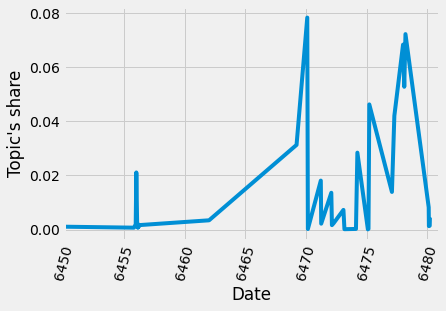

In [60]:
topic_temporal_distribution(data_temp_scaled['time'], data_temp_scaled[42])

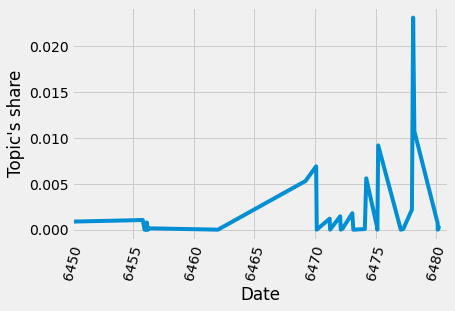

In [61]:
topic_temporal_distribution(data_temp_scaled['time'], data_temp_scaled[33])

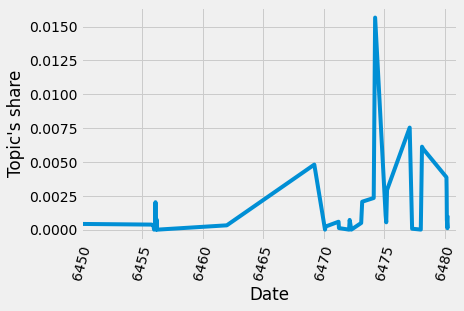

In [62]:
topic_temporal_distribution(data_temp_scaled['time'], data_temp_scaled[45])

### Is there any way to predict video popularity with topic that were used in the video?
Of course it is much more complex as it is very important who, when and what says about certain topic and how popular it is. But let us assume that there may be certain topics that are promoted and will help content creators to get higher number of views if they will somehow include certain topic in their video

#### First preprocess the views data and slice number of views to categories
The caregories choice was arbitrary but may be perceived differently by others

In [63]:
print(data["views"])

k = [x.replace(' ', '') for x in data["views"]]
k = [x.replace('\xa0', '') for x in k]

data["views"] = k
data["views"] = data["views"].astype(int)

data["Label"] = pd.cut(x=data["views"],
                     bins=[0,10000, 50000, 250000, 10000000],
                     labels=['Unpopular', 'Moderate', 'Popular', 'Viral'])

0        10 262 
1          9493 
2       112 836 
3          7152 
4        17 073 
         ...    
264         822 
265        1448 
266        3860 
267      66 707 
268      31 753 
Name: views, Length: 269, dtype: object


#### Popular videos analysis

In [64]:
X = data['text preprocessed']; y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

y_train = pd.get_dummies(y_train)['Popular']
y_test = pd.get_dummies(y_test)['Popular']

slda = tp.SLDAModel(k = 50, # number of topics
                    min_df = 0, # DF of tokens to be removed "from the bottom"
                    rm_top = 0, # how many tokens should be removed "from the top"
                    vars = 'b', # indicate binary response variable
                    alpha = 0.1,
                    eta = 0.01,
                    mu = 0,
                    nu_sq = 1,
                    glm_param = 1,
                    seed = 123
                   )

# adds documents to the corpus
for i in range(0,len(X_train)):
    slda.add_doc(X_train.iloc[i].strip().split(), y = [float(np.array(y_train)[i])])

for i in range(0, 2020, 20):
    print('Iteration: {:04} LL per word: {:.4}'.format(i, slda.ll_per_word))
    slda.train(20)


train_values = list(y_train)
test_values = list(y_test)

train_estimates = []
for i in range(0, len(X_train)):
    estimate = slda.estimate(slda.docs[i])
    train_estimates.append(float(estimate))

test_estimates = []
for i in range(0, len(X_test)):
    slda_test_doc = slda.make_doc(list(X_test)[i])
    slda.infer(slda_test_doc)
    test_estimates.append(float(slda.estimate(slda_test_doc)))

Iteration: 0000 LL per word: 0.0
Iteration: 0020 LL per word: -8.595


C:\Users\justy\AppData\Local\Temp/ipykernel_19572/3948872985.py:26: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  slda.train(20)


Iteration: 0040 LL per word: -8.386
Iteration: 0060 LL per word: -8.285
Iteration: 0080 LL per word: -8.22
Iteration: 0100 LL per word: -8.186
Iteration: 0120 LL per word: -8.167
Iteration: 0140 LL per word: -8.14
Iteration: 0160 LL per word: -8.13
Iteration: 0180 LL per word: -8.106
Iteration: 0200 LL per word: -8.095
Iteration: 0220 LL per word: -8.088
Iteration: 0240 LL per word: -8.082
Iteration: 0260 LL per word: -8.072
Iteration: 0280 LL per word: -8.072
Iteration: 0300 LL per word: -8.078
Iteration: 0320 LL per word: -8.074
Iteration: 0340 LL per word: -8.069
Iteration: 0360 LL per word: -8.065
Iteration: 0380 LL per word: -8.063
Iteration: 0400 LL per word: -8.059
Iteration: 0420 LL per word: -8.055
Iteration: 0440 LL per word: -8.05
Iteration: 0460 LL per word: -8.049
Iteration: 0480 LL per word: -8.052
Iteration: 0500 LL per word: -8.048
Iteration: 0520 LL per word: -8.041
Iteration: 0540 LL per word: -8.039
Iteration: 0560 LL per word: -8.036
Iteration: 0580 LL per word: -8.

C:\Users\justy\AppData\Local\Temp/ipykernel_19572/3948872985.py:39: RuntimeWarning: `words` should be an iterable of str.
  slda_test_doc = slda.make_doc(list(X_test)[i])


In [65]:
FPR_train, TPR_train, _  = roc_curve(train_values, train_estimates)
FPR_test, TPR_test, _  = roc_curve(test_values, test_estimates)

#### ROC- AUC
It seems that certain topics does not improve probability of getting 'Pupular' label for the video (50k-250k views).

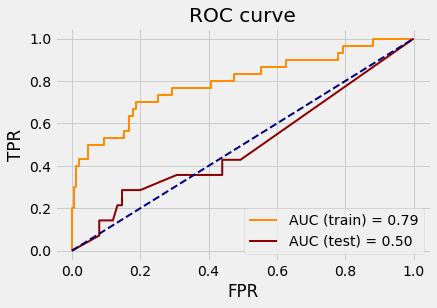

In [66]:
plt.figure()
lw = 2

plt.plot(FPR_train, TPR_train, color="darkorange", lw=lw, label="AUC (train) = %0.2f" % auc(FPR_train, TPR_train))
plt.plot(FPR_test, TPR_test, color="darkred", lw=lw, label="AUC (test) = %0.2f" % auc(FPR_test, TPR_test))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(loc="lower right")

#### Moderate videos analyis

We can see that ROC curve gives 0.68 on test sample. It seems that there are certain topics that may help us to fall into 'Moderate' category and the prediction will be better than tossing a coin probability.

Iteration: 0000 LL per word: 0.0
Iteration: 0020 LL per word: -8.592


C:\Users\justy\AppData\Local\Temp/ipykernel_19572/184721097.py:26: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  slda.train(20)


Iteration: 0040 LL per word: -8.387
Iteration: 0060 LL per word: -8.279
Iteration: 0080 LL per word: -8.226
Iteration: 0100 LL per word: -8.186
Iteration: 0120 LL per word: -8.165
Iteration: 0140 LL per word: -8.139
Iteration: 0160 LL per word: -8.116
Iteration: 0180 LL per word: -8.1
Iteration: 0200 LL per word: -8.082
Iteration: 0220 LL per word: -8.079
Iteration: 0240 LL per word: -8.068
Iteration: 0260 LL per word: -8.073
Iteration: 0280 LL per word: -8.073
Iteration: 0300 LL per word: -8.065
Iteration: 0320 LL per word: -8.056
Iteration: 0340 LL per word: -8.05
Iteration: 0360 LL per word: -8.048
Iteration: 0380 LL per word: -8.046
Iteration: 0400 LL per word: -8.043
Iteration: 0420 LL per word: -8.03
Iteration: 0440 LL per word: -8.029
Iteration: 0460 LL per word: -8.035
Iteration: 0480 LL per word: -8.026
Iteration: 0500 LL per word: -8.025
Iteration: 0520 LL per word: -8.025
Iteration: 0540 LL per word: -8.018
Iteration: 0560 LL per word: -8.021
Iteration: 0580 LL per word: -8.

C:\Users\justy\AppData\Local\Temp/ipykernel_19572/184721097.py:39: RuntimeWarning: `words` should be an iterable of str.
  slda_test_doc = slda.make_doc(list(X_test)[i])


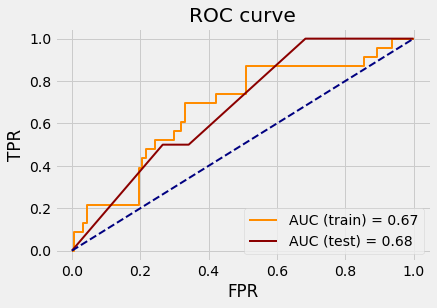

In [67]:
X = data['text preprocessed']; y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

y_train = pd.get_dummies(y_train)['Moderate']
y_test = pd.get_dummies(y_test)['Moderate']

slda = tp.SLDAModel(k = 50, # number of topics
                    min_df = 0, # DF of tokens to be removed "from the bottom"
                    rm_top = 0, # how many tokens should be removed "from the top"
                    vars = 'b', # indicate binary response variable
                    alpha = 0.1,
                    eta = 0.01,
                    mu = 0,
                    nu_sq = 1,
                    glm_param = 1,
                    seed = 123
                   )

# adds documents to the corpus
for i in range(0,len(X_train)):
    slda.add_doc(X_train.iloc[i].strip().split(), y = [float(np.array(y_train)[i])])

for i in range(0, 2020, 20):
    print('Iteration: {:04} LL per word: {:.4}'.format(i, slda.ll_per_word))
    slda.train(20)


train_values = list(y_train)
test_values = list(y_test)

train_estimates = []
for i in range(0, len(X_train)):
    estimate = slda.estimate(slda.docs[i])
    train_estimates.append(float(estimate))

test_estimates = []
for i in range(0, len(X_test)):
    slda_test_doc = slda.make_doc(list(X_test)[i])
    slda.infer(slda_test_doc)
    test_estimates.append(float(slda.estimate(slda_test_doc)))
    
FPR_train, TPR_train, _  = roc_curve(train_values, train_estimates)
FPR_test, TPR_test, _  = roc_curve(test_values, test_estimates)

plt.figure()
lw = 2

plt.plot(FPR_train, TPR_train, color="darkorange", lw=lw, label="AUC (train) = %0.2f" % auc(FPR_train, TPR_train))
plt.plot(FPR_test, TPR_test, color="darkred", lw=lw, label="AUC (test) = %0.2f" % auc(FPR_test, TPR_test))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(loc="lower right")

#### Viral videos analysis

There are also certain topics that may help us to predict if the video will be viral based on the topic used.

Iteration: 0000 LL per word: 0.0
Iteration: 0020 LL per word: -8.609
Iteration: 0040 LL per word: -8.399
Iteration: 0060 LL per word: -8.296


C:\Users\justy\AppData\Local\Temp/ipykernel_19572/1327398370.py:26: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  slda.train(20)


Iteration: 0080 LL per word: -8.228
Iteration: 0100 LL per word: -8.176
Iteration: 0120 LL per word: -8.135
Iteration: 0140 LL per word: -8.11
Iteration: 0160 LL per word: -8.093
Iteration: 0180 LL per word: -8.077
Iteration: 0200 LL per word: -8.071
Iteration: 0220 LL per word: -8.058
Iteration: 0240 LL per word: -8.05
Iteration: 0260 LL per word: -8.045
Iteration: 0280 LL per word: -8.042
Iteration: 0300 LL per word: -8.034
Iteration: 0320 LL per word: -8.036
Iteration: 0340 LL per word: -8.021
Iteration: 0360 LL per word: -8.021
Iteration: 0380 LL per word: -8.013
Iteration: 0400 LL per word: -8.009
Iteration: 0420 LL per word: -8.002
Iteration: 0440 LL per word: -8.002
Iteration: 0460 LL per word: -7.997
Iteration: 0480 LL per word: -7.994
Iteration: 0500 LL per word: -7.99
Iteration: 0520 LL per word: -7.989
Iteration: 0540 LL per word: -7.985
Iteration: 0560 LL per word: -7.994
Iteration: 0580 LL per word: -7.986
Iteration: 0600 LL per word: -7.998
Iteration: 0620 LL per word: -7

C:\Users\justy\AppData\Local\Temp/ipykernel_19572/1327398370.py:39: RuntimeWarning: `words` should be an iterable of str.
  slda_test_doc = slda.make_doc(list(X_test)[i])


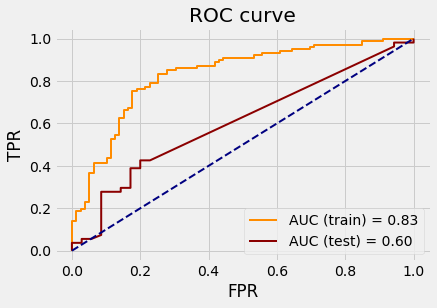

In [68]:
X = data['text preprocessed']; y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

y_train = pd.get_dummies(y_train)['Viral']
y_test = pd.get_dummies(y_test)['Viral']

slda = tp.SLDAModel(k = 50, # number of topics
                    min_df = 0, # DF of tokens to be removed "from the bottom"
                    rm_top = 0, # how many tokens should be removed "from the top"
                    vars = 'b', # indicate binary response variable
                    alpha = 0.1,
                    eta = 0.01,
                    mu = 0,
                    nu_sq = 1,
                    glm_param = 1,
                    seed = 123
                   )

# adds documents to the corpus
for i in range(0,len(X_train)):
    slda.add_doc(X_train.iloc[i].strip().split(), y = [float(np.array(y_train)[i])])

for i in range(0, 2020, 20):
    print('Iteration: {:04} LL per word: {:.4}'.format(i, slda.ll_per_word))
    slda.train(20)


train_values = list(y_train)
test_values = list(y_test)

train_estimates = []
for i in range(0, len(X_train)):
    estimate = slda.estimate(slda.docs[i])
    train_estimates.append(float(estimate))

test_estimates = []
for i in range(0, len(X_test)):
    slda_test_doc = slda.make_doc(list(X_test)[i])
    slda.infer(slda_test_doc)
    test_estimates.append(float(slda.estimate(slda_test_doc)))
    
FPR_train, TPR_train, _  = roc_curve(train_values, train_estimates)
FPR_test, TPR_test, _  = roc_curve(test_values, test_estimates)

plt.figure()
lw = 2

plt.plot(FPR_train, TPR_train, color="darkorange", lw=lw, label="AUC (train) = %0.2f" % auc(FPR_train, TPR_train))
plt.plot(FPR_test, TPR_test, color="darkred", lw=lw, label="AUC (test) = %0.2f" % auc(FPR_test, TPR_test))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(loc="lower right")

### Conclusion


Based on the analysis we can see that YouTube videos can be deffinitely analysed based on their transcriptions. What is more we can obtain some extra knowledge by analysing top words from obtained topics, analyse certain videos by topics, see how populat topics were over time or if some topics may influence the popularity of the video.